In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [10]:
from skimage.feature import local_binary_pattern

batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    # lbp
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    _x = local_binary_pattern(x, n_points, radius, method=METHOD)
    _x = 1 / (1 + np.exp(-_x))
    
    x = x * _x
    x = x.astype(np.uint8)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.RandomCrop((48,48)),
#     transforms.RandomRotation(180),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Feature Act 5

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_emb = nn.Flatten()(xfact2_3)
        x = self.classifier(x_emb)
        
        return x, x_emb

In [11]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [ ]:
model_path = './lbp_feature_act_5_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1130445003509521 cep_loss=1.782645583152771 triplet_loss=0.10864279419183731 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 1.192 | Avg.acc: 0.219



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.263
* Update optimal model
Epoch:  2


Loss=1.0294463634490967 cep_loss=1.6466503143310547 triplet_loss=0.10364033281803131 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 1.097 | Avg.acc: 0.288



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.330
* Update optimal model
Epoch:  3


Loss=0.9772340655326843 cep_loss=1.5593173503875732 triplet_loss=0.10410907119512558 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.967 | Avg.acc: 0.393



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.376
* Update optimal model
Epoch:  4


Loss=0.7884556651115417 cep_loss=1.2454745769500732 triplet_loss=0.10292720794677734 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.893 | Avg.acc: 0.449



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.878 | Avg. val_acc: 0.462
* Update optimal model
Epoch:  5


Loss=0.797734797000885 cep_loss=1.2620234489440918 triplet_loss=0.1013016626238823 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.855 | Avg.acc: 0.475



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.852 | Avg. val_acc: 0.468
* Update optimal model
Epoch:  6


Loss=0.8711518049240112 cep_loss=1.3823773860931396 triplet_loss=0.10431329160928726 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.832 | Avg.acc: 0.495



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.930 | Avg. val_acc: 0.437
Epoch:  7


Loss=0.8780061602592468 cep_loss=1.3940728902816772 triplet_loss=0.10390597581863403 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.815 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.797 | Avg. val_acc: 0.524
* Update optimal model
Epoch:  8


Loss=0.8864156603813171 cep_loss=1.407370686531067 triplet_loss=0.10498304665088654 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.801 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.847 | Avg. val_acc: 0.496
Epoch:  9


Loss=0.8022738695144653 cep_loss=1.2694686651229858 triplet_loss=0.10148149728775024 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.790 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.780 | Avg. val_acc: 0.547
* Update optimal model
Epoch:  10


Loss=0.6720763444900513 cep_loss=1.0523333549499512 triplet_loss=0.10169070959091187 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.781 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.763 | Avg. val_acc: 0.543
Epoch:  11


Loss=0.7821778655052185 cep_loss=1.2343026399612427 triplet_loss=0.10399053245782852 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.771 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.767 | Avg. val_acc: 0.539
Epoch:  12


Loss=0.8159281015396118 cep_loss=1.2906568050384521 triplet_loss=0.10383499413728714 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.764 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.783 | Avg. val_acc: 0.536
Epoch:  13


Loss=1.066442608833313 cep_loss=1.7067734003067017 triplet_loss=0.10594648122787476 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.761 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.764 | Avg. val_acc: 0.542
Epoch:  14


Loss=0.846092700958252 cep_loss=1.34064519405365 triplet_loss=0.10426392406225204 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.753 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.758 | Avg. val_acc: 0.548
* Update optimal model
Epoch:  15


Loss=0.6938982009887695 cep_loss=1.0868147611618042 triplet_loss=0.10452327132225037 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.748 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.788 | Avg. val_acc: 0.541
Epoch:  16


Loss=0.6460586190223694 cep_loss=1.013319492340088 triplet_loss=0.09516730904579163 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.743 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.746 | Avg. val_acc: 0.559
* Update optimal model
Epoch:  17


Loss=0.878122866153717 cep_loss=1.392075777053833 triplet_loss=0.1071934774518013 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.740 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.757 | Avg. val_acc: 0.544
Epoch:  18


Loss=0.8674012422561646 cep_loss=1.3749998807907104 triplet_loss=0.10600315034389496 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.736 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.783 | Avg. val_acc: 0.538
Epoch:  19


Loss=0.5900028944015503 cep_loss=0.9111542701721191 triplet_loss=0.1082756444811821 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.736 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.722 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  20


Loss=0.6595906615257263 cep_loss=1.0323933362960815 triplet_loss=0.1003865972161293 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.731 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.763 | Avg. val_acc: 0.548
Epoch:  21


Loss=0.6626566052436829 cep_loss=1.0380403995513916 triplet_loss=0.09958085417747498 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.730 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.737 | Avg. val_acc: 0.564
Epoch:  22


Loss=1.0626840591430664 cep_loss=1.7034978866577148 triplet_loss=0.10146334767341614 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.724 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.808 | Avg. val_acc: 0.538
Epoch:  23


Loss=0.8367968797683716 cep_loss=1.3262485265731812 triplet_loss=0.10261936485767365 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.724 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.768 | Avg. val_acc: 0.545
Epoch:  24


Loss=0.7921242117881775 cep_loss=1.2543267011642456 triplet_loss=0.0988202691078186 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.717 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.709 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  25


Loss=0.9141181707382202 cep_loss=1.4526793956756592 triplet_loss=0.10627634078264236 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.720 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.740 | Avg. val_acc: 0.555
Epoch:  26


Loss=0.7311445474624634 cep_loss=1.1479915380477905 triplet_loss=0.10587393492460251 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.718 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.722 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  27


Loss=0.8432986736297607 cep_loss=1.3348079919815063 triplet_loss=0.1060345321893692 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.715 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.756 | Avg. val_acc: 0.555
Epoch:  28


Loss=0.9054331183433533 cep_loss=1.4307842254638672 triplet_loss=0.11740636825561523 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.710 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.726 | Avg. val_acc: 0.576
Epoch:  29


Loss=0.8626646399497986 cep_loss=1.3678250312805176 triplet_loss=0.10492399334907532 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.714 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.743 | Avg. val_acc: 0.562
Epoch:  30


Loss=0.5193484425544739 cep_loss=0.8024442195892334 triplet_loss=0.09470468014478683 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.711 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.733 | Avg. val_acc: 0.565
Epoch:  31


Loss=0.7279398441314697 cep_loss=1.1487902402877808 triplet_loss=0.09666413068771362 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.713 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.709 | Avg. val_acc: 0.577
* Update optimal model
Epoch:  32


Loss=0.6132282614707947 cep_loss=0.9526444673538208 triplet_loss=0.10410390049219131 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.708 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.735 | Avg. val_acc: 0.577
Epoch    32: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  33


Loss=0.7092604637145996 cep_loss=1.1128559112548828 triplet_loss=0.10386723279953003 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.677 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.695 | Avg. val_acc: 0.593
* Update optimal model
Epoch:  34


Loss=0.5602309703826904 cep_loss=0.8703569173812866 triplet_loss=0.09504201263189316 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.673 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.698 | Avg. val_acc: 0.591
Epoch:  35


Loss=0.5546371936798096 cep_loss=0.860042929649353 triplet_loss=0.0965285524725914 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.666 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.682 | Avg. val_acc: 0.601
* Update optimal model
Epoch:  36


Loss=0.5682528614997864 cep_loss=0.8823461532592773 triplet_loss=0.09711286425590515 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.664 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.679 | Avg. val_acc: 0.608
* Update optimal model
Epoch:  37


Loss=0.7816542983055115 cep_loss=1.2345002889633179 triplet_loss=0.10238521546125412 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.661 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.685 | Avg. val_acc: 0.601
Epoch:  38


Loss=0.5253649353981018 cep_loss=0.8107198476791382 triplet_loss=0.09733248502016068 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.658 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.683 | Avg. val_acc: 0.598
Epoch:  39


Loss=0.6002073884010315 cep_loss=0.931453287601471 triplet_loss=0.10333847999572754 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.658 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.684 | Avg. val_acc: 0.598
Epoch:  40


Loss=0.8190641403198242 cep_loss=1.2978334426879883 triplet_loss=0.10091009736061096 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.659 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.675 | Avg. val_acc: 0.607
Epoch:  41


Loss=0.6190527081489563 cep_loss=0.9632797241210938 triplet_loss=0.10271207243204117 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.655 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.685 | Avg. val_acc: 0.607
Epoch:  42


Loss=0.7257686853408813 cep_loss=1.1424461603164673 triplet_loss=0.10075239092111588 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.653 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.693 | Avg. val_acc: 0.592
Epoch:  43


Loss=0.7055613398551941 cep_loss=1.1134684085845947 triplet_loss=0.09370072931051254 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.649 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.683 | Avg. val_acc: 0.599
Epoch:  44


Loss=0.6627296209335327 cep_loss=1.037060260772705 triplet_loss=0.1012335792183876 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.649 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.686 | Avg. val_acc: 0.599
Epoch:  45


Loss=0.7233577370643616 cep_loss=1.1382302045822144 triplet_loss=0.10104896873235703 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.644 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.700 | Avg. val_acc: 0.588
Epoch:  46


Loss=0.6573948860168457 cep_loss=1.0292028188705444 triplet_loss=0.09968291223049164 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.646 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.687 | Avg. val_acc: 0.602
Epoch:  47


Loss=0.5941821932792664 cep_loss=0.9241693615913391 triplet_loss=0.09920132905244827 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.644 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.689 | Avg. val_acc: 0.602
Epoch:  48


Loss=0.7296318411827087 cep_loss=1.148925542831421 triplet_loss=0.10069112479686737 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.644 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.683 | Avg. val_acc: 0.604
Epoch    48: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  49


Loss=0.5848178267478943 cep_loss=0.907701313495636 triplet_loss=0.10049255192279816 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.621 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.676 | Avg. val_acc: 0.608
Epoch:  50


Loss=0.8658748865127563 cep_loss=1.3629634380340576 triplet_loss=0.12024190276861191 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.611 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.669 | Avg. val_acc: 0.605
Epoch:  51


Loss=0.5124014019966125 cep_loss=0.789426326751709 triplet_loss=0.09686388820409775 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.610 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.668 | Avg. val_acc: 0.611
* Update optimal model
Epoch:  52


Loss=0.6817575097084045 cep_loss=1.0685769319534302 triplet_loss=0.10152831673622131 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.81it/s]

- Avg.loss: 0.604 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.670 | Avg. val_acc: 0.608
Epoch:  53


Loss=0.74482262134552 cep_loss=1.1753793954849243 triplet_loss=0.0989873856306076 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.601 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.670 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  54


Loss=0.6531399488449097 cep_loss=1.0245505571365356 triplet_loss=0.0960240289568901 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.604 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.669 | Avg. val_acc: 0.610
Epoch:  55


Loss=0.6279196739196777 cep_loss=0.9815878868103027 triplet_loss=0.0974172055721283 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.599 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.662 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  56


Loss=0.6811416745185852 cep_loss=1.067320704460144 triplet_loss=0.10187306255102158 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.598 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.661 | Avg. val_acc: 0.620
* Update optimal model
Epoch:  57


Loss=0.6549712419509888 cep_loss=1.0223790407180786 triplet_loss=0.10385946929454803 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.597 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.676 | Avg. val_acc: 0.610
Epoch:  58


Loss=0.5780524015426636 cep_loss=0.8986098766326904 triplet_loss=0.09721600264310837 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.592 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.670 | Avg. val_acc: 0.612
Epoch:  59


Loss=0.6347888708114624 cep_loss=0.9919231534004211 triplet_loss=0.09908740967512131 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.592 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.663 | Avg. val_acc: 0.618
Epoch:  60


Loss=0.5779538154602051 cep_loss=0.8945120573043823 triplet_loss=0.10311631858348846 Batch_id=34 Accuracy=0.6796875:  16%|█▌        | 35/225 [00:14<01:06,  2.86it/s]

([<matplotlib.lines.Line2D at 0x7f7a318d57f0>,
 0.6330454165505712)

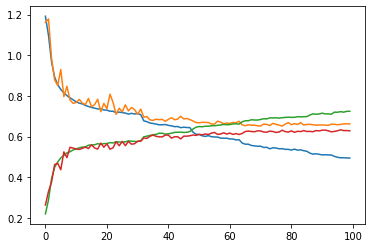

In [13]:
plt.plot(hist), best_acc

In [14]:
model = torch.load('lbp_feature_act_5_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = (0.6*loss) + (0.4*triplet_loss)

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.648 | Avg. val_acc: 0.630
